## Comparison of the genetic load caused by introgressed and non-introgressed alleles

_Genetic load_ is the relative reduction in average fitness caused by deleterious alleles compared to the maximum absolute fitness.

I considered three models (example in the plot bellow):

* classic Gravel et al. demographic model
* model of a constant $N_e = 10000$
* model of an initial linear growth until $N_e = 10000$ followed by a period exponential growth

In [1]:
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(lazyeval))
suppressPackageStartupMessages(library(reshape2))

suppressPackageStartupMessages(source("../R/process_slim_output.R"))

Conflicts with tidy packages ---------------------------------------------------


In [2]:
traject_dir <- "../simulations/different_models"

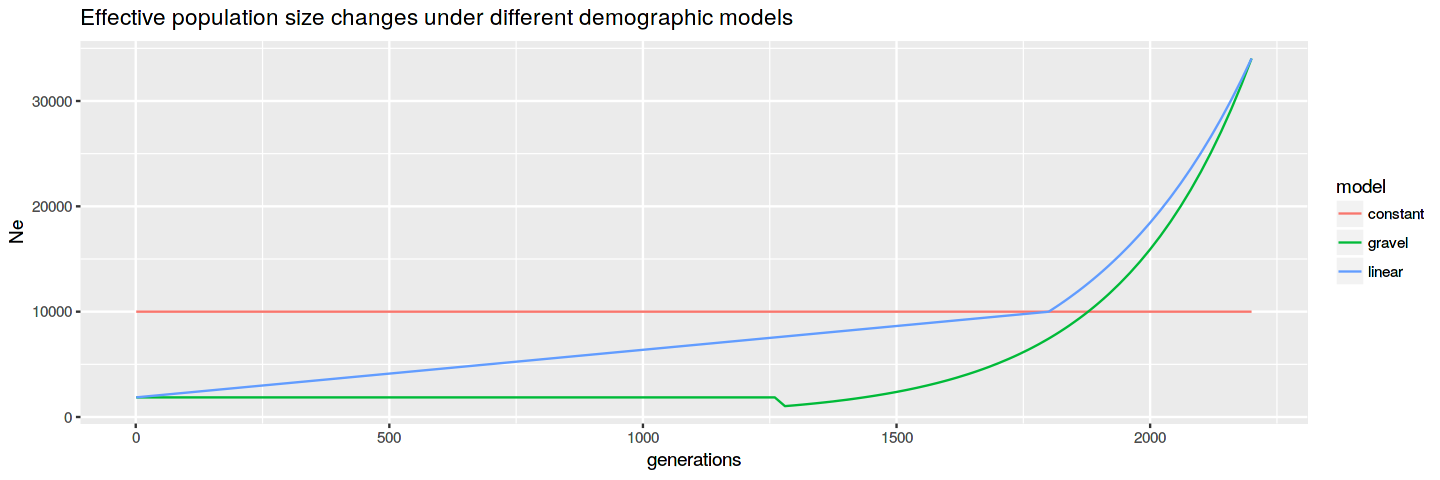

In [3]:
options(repr.plot.width=12, repr.plot.height=4)

# the custom SLiM output format includes a column with a Ne at each time-point
# this simply plots the values in this column for different simulation replicates
rbind(
    read.table(file.path(traject_dir, "constant__h_0.5__init_nea_0.1__rep_1__exonic_sites.txt"), header=TRUE) %>% mutate(model="constant"),
    read.table(file.path(traject_dir, "gravel__h_0.5__init_nea_0.1__rep_1__exonic_sites.txt"), header=TRUE)   %>% mutate(model="gravel"),
    read.table(file.path(traject_dir, "linear__h_0.5__init_nea_0.1__rep_1__exonic_sites.txt"), header=TRUE)   %>% mutate(model="linear")
) %>%
ggplot(aes(gen, Ne, color=model)) +
    geom_line() +
    labs(title="Effective population size changes under different demographic models",
         x="generations")

### Load the SLiM simulation output files for each model at different timepoints

This is a lot of data to parse (~57Gb), so we're going to do this in parallel.

Still, because the code is processing mutations in every individual's genome in generations 1-50, for three different demographic models (see above), this is going to take several hours to finish (about 6 hours on full 56 cores regime).

The final processed `data.frame` will be saved as an `Rds` file, and the processing code will not be re-run in case that file is present. 

In [4]:
library(parallel)

In [5]:
(gens <- c(1:30))
(models <- c("constant", "linear", "gravel"))
(dominances <- c("1.0", "0.9", "0.5", "0.1", "0.0"))

[1]  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
[26] 26 27 28 29 30

[1] "constant" "linear"   "gravel"

[1] "1.0" "0.9" "0.5" "0.1" "0.0"

Load the exonic and nonexonic mutations in all specified generations for all three models:

In [6]:
combinations <- expand.grid(gen=gens, model=models, h=dominances)

In [7]:
if (!file.exists("../tmp/loads_all.Rds")) {

loads_list <-
    mclapply(
        1 : nrow(combinations),
        function(i) {
            model <- combinations[i, "model"]
            gen <- as.integer(combinations[i, "gen"])
            h <- combinations[i, "h"]

            # load the whole SLiM output file first
            slim_file <- read_slim_file(file.path(traject_dir,
                                                  paste0(model,
                                                         "__h_",
                                                         h,
                                                         "__init_nea_0.1__rep_1__dump_gen_",
                                                         gen,
                                                         ".txt")))

            # load Neanderthal- and MH-specific deleterious variants segregating
            # in the MH population
            nea_muts <- read_mutations(slim_file, "m0", "p2")
            mh_muts <- read_mutations(slim_file, "m0", "p1", t=50000)
            
            # load tables with IDs of all MH individuals and their genomes
            mh_indivs <- read_individuals(slim_file, "p3")
            mh_genomes <- read_genomes(slim_file, "p3")
            
            # match each mutation in each individual genome against its
            # selection coefficient and other data
            nea_muts_per_genome <- inner_join(mh_genomes, nea_muts, by="mut_id")
            mh_muts_per_genome <- inner_join(mh_genomes, mh_muts, by="mut_id")

            # calculate individual genetic loads caused by Nea variants
            nea_loads <- tibble(
                indiv_id=mh_indivs$indiv_id,
                load=sapply(mh_indivs$indiv_id, calculate_indiv_load, muts_per_genome=nea_muts_per_genome),
                kind="Nea"
            )

            # calculate individual genetic loads caused by MH variants
            mh_loads <- tibble(
                indiv_id=mh_indivs$indiv_id,
                load=sapply(mh_indivs$indiv_id, calculate_indiv_load, muts_per_genome=mh_muts_per_genome),
                kind="MH"
            )

            bind_rows(nea_loads, mh_loads) %>% mutate(gen=gen, model=model, h=h)
            
        },
        mc.cores=40
    )

loads <- bind_rows(loads_list) %>% mutate(gen=factor(gen))
saveRDS(loads, "../tmp/loads_all.Rds")

} else {
    
loads <- readRDS("../tmp/loads_all.Rds")

}

## Contribution of Neanderthal and MH mutations to genetic load of each individual

Each dot in the plot bellow is a single individual. It's position is determined by the genetic load carried by that individual's genome caused by Neanderthal introgressed (y axis) or modern-human (x-axis) mutations.

Each panel is a snapshot of the simulation at a particular generation.

## Dynamics of the distribution of genetic loads caused by Nea. or MH mutations

This is equivalent to looking at the projection of the plots above on the y-axis or x-axis only.

In [8]:
options(repr.plot.width=12, repr.plot.height=10)

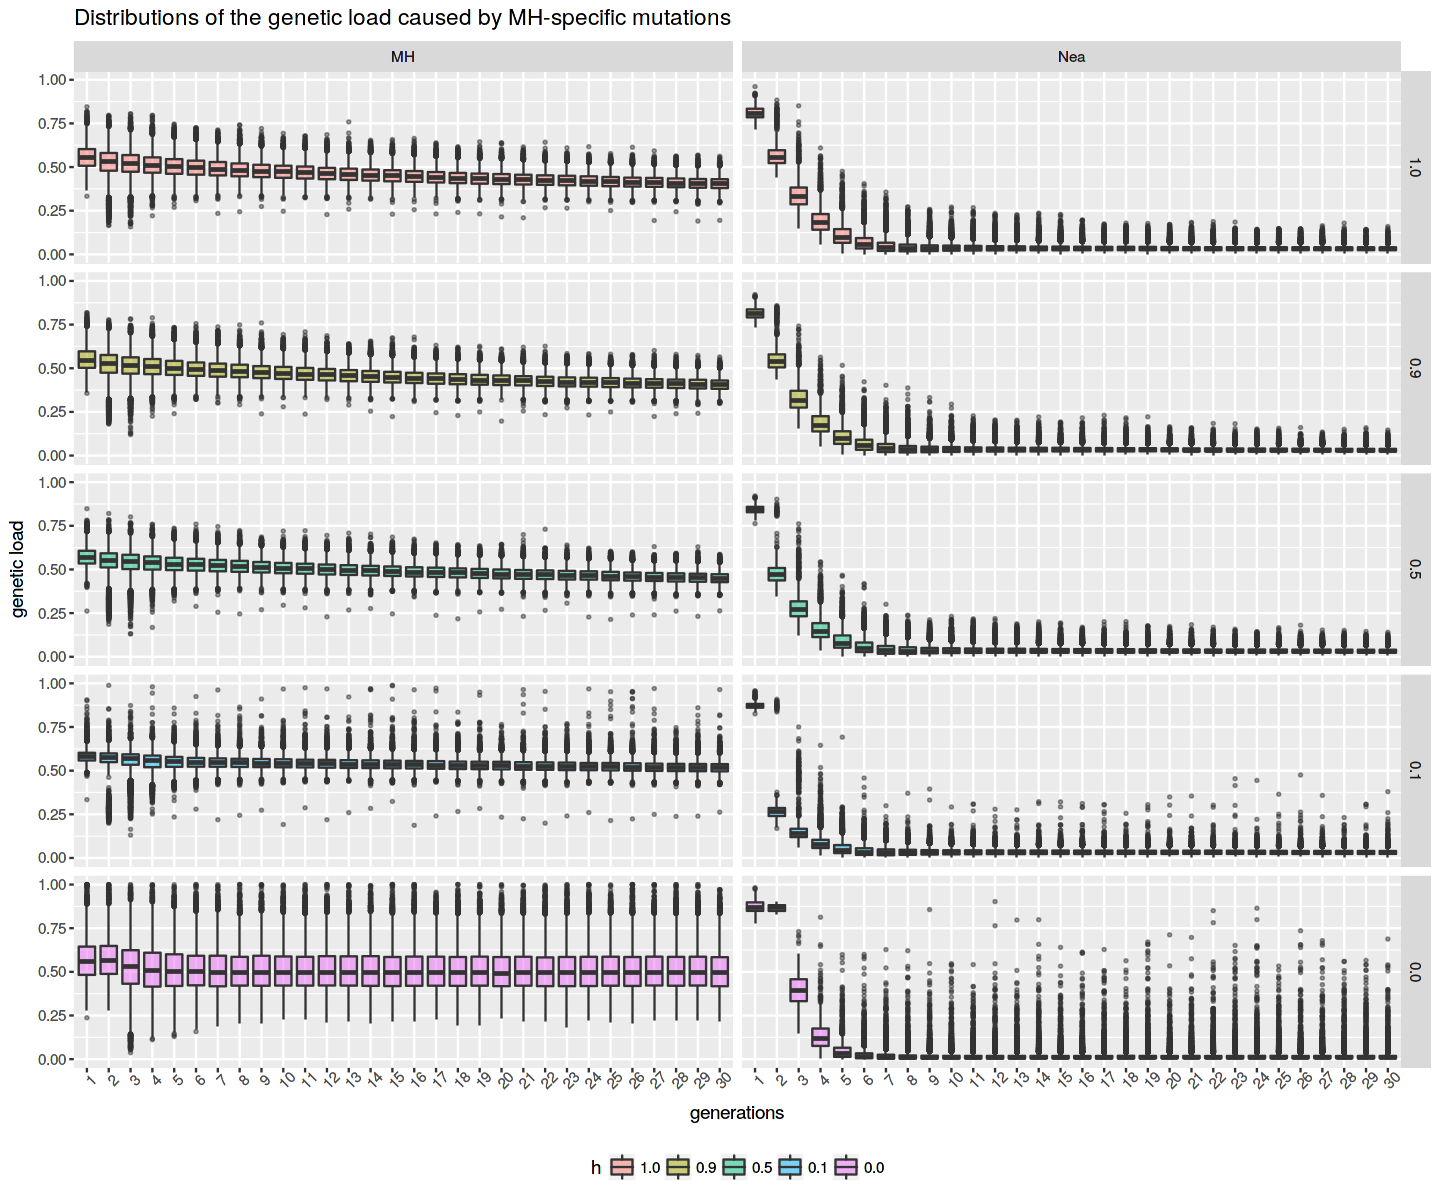

In [9]:
p <- filter(loads, model == "constant", load > 0, gen %in% 1:30) %>%
    ggplot(aes(gen, load, group=gen, fill=h)) +
    geom_boxplot(alpha=1/2, outlier.size=0.5) +
    facet_grid(h ~ kind) +
    labs(title="Distributions of the genetic load caused by MH-specific mutations",
         x="generations", y="genetic load") +
    theme(legend.position="bottom",
          axis.text.x=element_text(angle=45))

p